<a href="https://colab.research.google.com/github/joaopedromattos/pyGAT/blob/master/GATEventEmbedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAT Event Embedding
This notebook establishes a training pipeline for our Event Embedding model.

## Installing our libraries and required scripts

In [1]:
!git clone https://github.com/joaopedromattos/pyGAT
!pip install --quiet spektral
!pip install git+https://github.com/rmarcacini/sentence-transformers
!pip install gdown
!gdown https://drive.google.com/uc?id=1NV5t1YhyyOzMF5zAovfbSLdZZLvqrfZ_
!unzip distiluse-base-multilingual-cased.zip -d language_model

Cloning into 'pyGAT'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 195 (delta 16), reused 25 (delta 9), pack-reused 163
Receiving objects: 100% (195/195), 298.73 KiB | 551.00 KiB/s, done.
Resolving deltas: 100% (105/105), done.
     |████████████████████████████████| 102kB 2.6MB/s 
  Cloning https://github.com/rmarcacini/sentence-transformers to /tmp/pip-req-build-3nms56fs
  Running command git clone -q https://github.com/rmarcacini/sentence-transformers /tmp/pip-req-build-3nms56fs
     |████████████████████████████████| 890kB 2.8MB/s 
     |████████████████████████████████| 1.1MB 17.1MB/s 
     |████████████████████████████████| 890kB 19.9MB/s 
     |████████████████████████████████| 3.0MB 26.2MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.6-cp36-none-any.whl size=101874 sha256=206bc1a453185d28fdc7a833f05b68c79eb24929b2876755420c50c062aca75f
  S

In [2]:
import os

os.chdir('./pyGAT')

In [3]:
import networkx as nx
from tqdm import tqdm
import pandas as pd
from google.colab import auth
from google.cloud import bigquery
from google.cloud import bigquery_storage
import numpy as np
import logging
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer, LabelEncoder
from event_graph_utils import mount_graph, regularization, process_event_dataset_from_networkx
from train import GAT_wrapper

auth.authenticate_user()
print('Authenticated')

Authenticated


## Retrieving events from GDELT in order to create our graph

In [33]:
%%bigquery --project gat-event-embedding df
SELECT REGEXP_EXTRACT(Extras, '<PAGE_TITLE>(.*)</PAGE_TITLE>') text, * FROM `gdelt-bq.gdeltv2.gkg_partitioned` WHERE DATE(_PARTITIONTIME) = "2020-10-05" LIMIT 150

## Creating our graph and applying a regularization process

In [35]:
G = mount_graph(df)

Creating graph...
2020-11-04 14:34:35 - Load pretrained SentenceTransformer: ../language_model
2020-11-04 14:34:35 - Load SentenceTransformer from folder: ../language_model
2020-11-04 14:34:39 - Use pytorch device: cuda



Graph loaded: OK - 	 Nodes: 1251 	  edges: 3725


In [36]:
G = regularization(G, 512)

## Visualization of the label distribuition

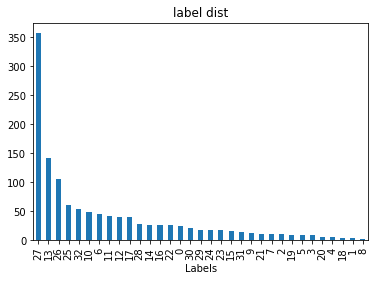

In [59]:
_, _, labels, _, _, _ = process_event_dataset_from_networkx(G)
pd.value_counts(labels).plot(kind='bar', title="label dist", xlabel="Labels");

## Saving our dataset

In [14]:
nx.write_gpickle(G, 'dataset.gpickle')

## Training

In [40]:
gat = GAT_wrapper({"alpha": 0.2, "cuda": True, "dropout": 0.6, "epochs": 10_000, "fastmode": False, "hidden": 8, "lr": 0.005, "nb_heads": 8, "no_cuda": False, "patience": 100, "seed": 72, "sparse": False, "weight_decay": 0.0005})
gat.train_pipeline(G, custom_function=True, function=process_event_dataset_from_networkx)

[LOAD DATA]: cora
Epoch: 0001 loss_train: 3.5177 acc_train: 0.0213 loss_val: 3.3968 acc_val: 0.1920 time: 0.5406s
Epoch: 0002 loss_train: 3.4097 acc_train: 0.0760 loss_val: 3.3079 acc_val: 0.3240 time: 0.4412s
Epoch: 0003 loss_train: 3.2905 acc_train: 0.1680 loss_val: 3.2196 acc_val: 0.4240 time: 0.4287s
Epoch: 0004 loss_train: 3.2392 acc_train: 0.2280 loss_val: 3.1327 acc_val: 0.4680 time: 0.4190s
Epoch: 0005 loss_train: 3.1742 acc_train: 0.2067 loss_val: 3.0470 acc_val: 0.4680 time: 0.4273s
Epoch: 0006 loss_train: 3.0928 acc_train: 0.2480 loss_val: 2.9630 acc_val: 0.4680 time: 0.5195s
Epoch: 0007 loss_train: 2.9887 acc_train: 0.2840 loss_val: 2.8806 acc_val: 0.4520 time: 0.4939s
Epoch: 0008 loss_train: 2.9598 acc_train: 0.2800 loss_val: 2.8008 acc_val: 0.4520 time: 0.4212s
Epoch: 0009 loss_train: 2.8604 acc_train: 0.2960 loss_val: 2.7244 acc_val: 0.4520 time: 0.4266s
Epoch: 0010 loss_train: 2.8205 acc_train: 0.3080 loss_val: 2.6531 acc_val: 0.4520 time: 0.5250s
Epoch: 0011 loss_train

GAT(
  (attention_0): GraphAttentionLayer (512 -> 8)
  (attention_1): GraphAttentionLayer (512 -> 8)
  (attention_2): GraphAttentionLayer (512 -> 8)
  (attention_3): GraphAttentionLayer (512 -> 8)
  (attention_4): GraphAttentionLayer (512 -> 8)
  (attention_5): GraphAttentionLayer (512 -> 8)
  (attention_6): GraphAttentionLayer (512 -> 8)
  (attention_7): GraphAttentionLayer (512 -> 8)
  (out_att): GraphAttentionLayer (64 -> 33)
)